In [1]:
import datetime
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from PIL import Image
import os
from random import shuffle
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

Using TensorFlow backend.


We will be using this later to record how long it takes to train our model.

In [2]:
now = datetime.datetime.now
print (now())

2020-05-30 18:24:52.141634


#### Instantiation of hyperparameters

Here we instantiate the values of hyperparameters that we will be using later. We will stick to the parameters similar to the deep neural network except for the `epochs` which is reduced, as CNN are more computationally expensive.

Some terms to define for my [reference](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9):<br>
1) `batch_size`: total # of training examples present in the dataset<br>
2) `number of batches`: # of sets/parts a dataset is divided.<br>
3) `iterations`: # of batches needed to complete one epoch. AKA number of batches.<br>
4) `epoch`: when an entire dataset is passed once, forward and backward through the neural network.

We have 18 images in the training data. <br>
Batch size of 3 images are to be passed in 6 iterations/number of batches for one epoch.<br>
OR <br>
Batch size of 6 images are to be passed in 3 iterations/number of batches for one epoch.

In [25]:
# I will go with the first choice for the trial
batch_size = 3
num_classes = 6
epochs = 6

The sizes differ for the images and they should be of the same dimensions.

#### Image Information
As the scrapped data is not labelled, I decided which images to be considered as medium congestion and low congestion. The test data has a 50-50 balance of the medium vs low congestion.
Now, I would need to label the images as such that the image is labelled as class `0` or `1`.

In [5]:
DIR = './data/train'

# First, I need to figure how I should format the height x width image dimensions
# to input to a keras model
def get_img_statistics():
    heights = []
    widths = []
    img_count = 0
    for img in os.listdir(DIR):
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])
            img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

get_img_statistics()

Average Height: 458
Max Height: 480
Min Height: 288


Average Width: 611
Max Width: 640
Min Width: 384


The sizes differ for the images and they should be of the same dimensions.

#### Labelling image data
As the scrapped data is not labelled, I decided which images to be considered as medium congestion and low congestion. The test data has a 50-50 balance of the medium vs low congestion.
Now, I would need to label the images as such that the image is labelled as class **`0, 1` for low congestion** or **`1, 0` for medium congestion**.

In [13]:
def label_img(img_name):
    
    img_name = img_name.split('.')[0]
    
    if img_name.endswith('c'): 
        return np.array([1, 0])
    elif img_name.endswith('n'): 
        return np.array([0, 1])
    else:
        return 

#### Image formatting 
Images that are used as inputs in a Keras model must be formatted. Therefore the input dimensions are specified, as the dimensions of all the images differ vastl, so that the images are uniform before the model is trained on these images.

In [14]:
img_size = 300

def load_training_data():
    train_data = []
    for img in os.listdir(DIR):
        label = label_img(img)
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((img_size, img_size), Image.ANTIALIAS)
            train_data.append([np.array(img), label])
            
    shuffle(train_data)
    return train_data

In [15]:
#list object
train_data = load_training_data()

In [16]:
#list item has 2 items: 1) the array, 2)the label
len(train_data[4])

2

In [17]:
train_data[4]

[array([[253, 253, 252, ..., 218, 219, 213],
        [253, 253, 252, ..., 212, 206, 209],
        [253, 253, 252, ..., 210, 211, 215],
        ...,
        [ 63,  67,  63, ...,  43,  61,  61],
        [ 64,  65,  64, ...,  16,  29,  71],
        [ 63,  64,  66, ...,  32,  24,  38]], dtype=uint8), array([0, 1])]

In [18]:
train_data[4][0]

array([[253, 253, 252, ..., 218, 219, 213],
       [253, 253, 252, ..., 212, 206, 209],
       [253, 253, 252, ..., 210, 211, 215],
       ...,
       [ 63,  67,  63, ...,  43,  61,  61],
       [ 64,  65,  64, ...,  16,  29,  71],
       [ 63,  64,  66, ...,  32,  24,  38]], dtype=uint8)

In [19]:
train_data[4][1]

array([0, 1])

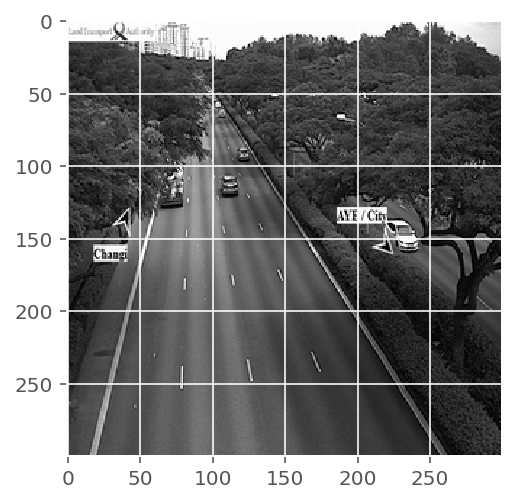

In [20]:
plt.imshow(train_data[4][0], cmap = 'gist_gray')

#### Assembling a simple CNN
I will be using one-hot vector encoding as it produces better result than encoding each label with ‘0’ or ‘1’.

In [21]:
#array object
#collate all images after reshaping
train_images = np.array([i[0] for i in train_data]).reshape(-1, img_size, img_size, 1)
#collate all labels
train_labels = np.array([i[1] for i in train_data])

In [26]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

The model experiences overfitting when accuracy reaches a 100%.

In [ ]:
#verbose=1 will show you an animated progress bar 
model.fit(train_images, train_labels, batch_size = batch_size, epochs = 6, verbose = 1) #batch_size = 50, epochs = 5 

Epoch 1/6
18/18 [==============================] - 11s 584ms/step - loss: 1.4388 - acc: 0.5556
Epoch 2/6
18/18 [==============================] - 4s 217ms/step - loss: 0.4702 - acc: 0.8889
Epoch 3/6
18/18 [==============================] - 4s 220ms/step - loss: 0.2074 - acc: 0.8889
Epoch 4/6
 6/18 [=========>....................] - ETA: 3s - loss: 0.0103 - acc: 1.0000

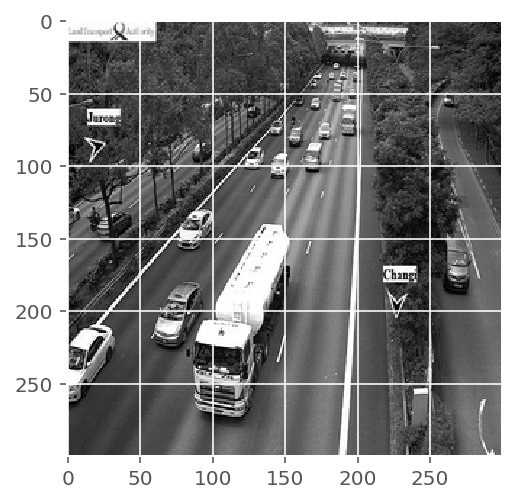

In [13]:
# Test on Test Set
TEST_DIR = './data/validation'
def load_test_data():
    test_data = []
    for img in os.listdir(TEST_DIR):
        label = label_img(img)
        path = os.path.join(TEST_DIR, img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((img_size, img_size), Image.ANTIALIAS)
            test_data.append([np.array(img), label])
    shuffle(test_data)
    return test_data


test_data = load_test_data()    
plt.imshow(test_data[2][0], cmap = 'gist_gray')

In [15]:
test_images = np.array([i[0] for i in test_data]).reshape(-1, img_size, img_size, 1)
test_labels = np.array([i[1] for i in test_data])

loss, acc = model.evaluate(test_images, test_labels, verbose = 0)
print(acc * 100)

44.44444477558136
